In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from preprocessing import *
from charts_and_write import *

from sklearn.naive_bayes import GaussianNB


# Naive Bayes

Este es un algoritmo para clasificación basado en la probabilidad de futuros resultados. Se basa en el teorema de bayes y es bastante rápido. Se lo conoce por su efectividad en filtros de spam.

## Preprocesamiento

En nuestro script preprocessing.py tenemos definidas ya funciones que nos van a servir para descargar los datos crudos y luego prepararlos para luego poder aplicarle ingeniería de features. La función prepararDatosExistentes 

In [3]:
download_raw_data()

In [4]:
#datasets train-test y holdout 
data_train = pd.read_csv("impuestos_train.cvs")
data_holdout = pd.read_csv("impuestos_holdout.cvs")
#llenamos los nulls y borramos columnas que no se usan
data_train, data_holdout = prepare_existing_data(data_train, data_holdout)


## Selección de features 1


Podemos usar los features que ya vienen en el dataset y ademas generar nuevos a partir de ellos. Para empezar de entrada vamos a descartar algunos que ya en el TP1 vimos que no aportaban como son barrio y educacion alcanzada. 
Luego, de los features ya existentes va a haber un grupo, los categoricos, que al no ser numericos vamos a tener que utilizar un encodeo para poder entrenar el modelo. La mayoria de ellos no tienen un orden entonces vamos a usar nuestra función de one hot encoding, que genera una columna nueva por cada valor posible. Para el caso de los que sí tienen orden vamos a utilizar un encodeo propio con la funcion "encoding_sorted". Ambas funciones estan en el script de preprocessing.py.


In [5]:
columns_one_hot = ["estado_marital", "categoria_de_trabajo", "rol_familiar_registrado", "religion", "trabajo", "genero"]
data_train_v1 = encode_one_hot(data_train, columns_one_hot)
columns_sorted_numeric = ["educacion"]
data_train_v1 = encoding_sorted(data_train_v1, columns_sorted_numeric)

In [6]:
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(data_train_v1.drop(columns={"tiene_alto_valor_adquisitivo"}), data_train_v1["tiene_alto_valor_adquisitivo"], random_state=42)

## Selección de features 2

Para la segunda selección vamos a agregar features obtenidos a partir del analisis del TP1, que son la transformación de edad a decil y de gancnaias en bolsa a cuartil.
El feature edad lo vamos a reemplazar por el decil al que pertenece en el dataset de entrenamiento, y vamos a reemplazar el feature de ganancias y perdidas en la bolsa por uno "bolsa" que representará el cuartil al que pertenece, en caso de ganancia, 0 en caso de no tener actividad, y un valor negativo correspondiente al cuartil en el caso de perdidas. Así, los casos que mas perdida tienen van a tener el valor -4, y los que mas ganancia tienen van a tener el valor 4.


In [7]:
columns_one_hot = ["estado_marital", "categoria_de_trabajo", "rol_familiar_registrado", "religion", "trabajo", "genero"]
data_train_v2 = encode_one_hot(data_train,columns_one_hot)
columns_sorted_numeric = ["educacion", "edad", "bolsa"]
data_train_v2 = encoding_sorted(data_train_v2, columns_sorted_numeric)

In [8]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(data_train_v2.drop(columns={"tiene_alto_valor_adquisitivo"}), data_train_v2["tiene_alto_valor_adquisitivo"], random_state=42)

## Prueba Gaussian Naive Bayes por defecto

### Seleccion 1

In [9]:
gnb = GaussianNB()
gnb.fit(X_train_v1, y_train_v1)
y_pred = gnb.predict(X_test_v1)
show_metrics(gnb, y_pred, y_test_v1, X_test_v1, "naive bayes")

Accuracy: 0.7917946198255743
----------------------------------------------
Precision: 0.825116761805916
----------------------------------------------
Recall: 0.5393487109905021
----------------------------------------------
F1_score: 0.6523076923076924
----------------------------------------------
AUC-ROC score para naive bayes: 0.896


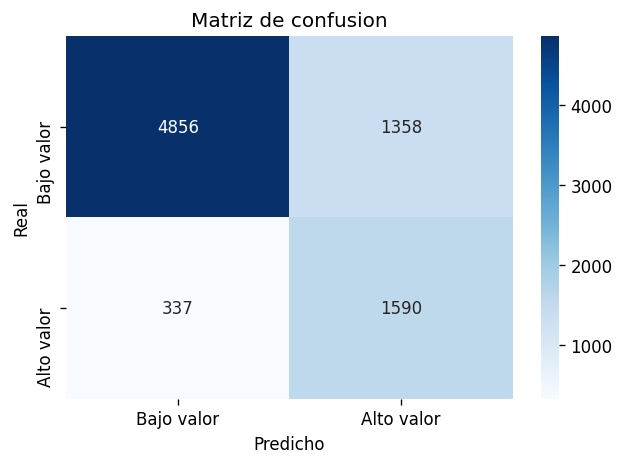

In [10]:
show_confusion_matrix(y_pred,y_test_v1)

### Seleccion 2

In [11]:
gnb = GaussianNB()
gnb.fit(X_train_v2, y_train_v2)
y_pred = gnb.predict(X_test_v2)
show_metrics(gnb, y_pred, y_test_v2, X_test_v2, "naive_bayes")

Accuracy: 0.8077631740572411
----------------------------------------------
Precision: 0.8053969901401141
----------------------------------------------
Recall: 0.5660102115244348
----------------------------------------------
F1_score: 0.6648104519168987
----------------------------------------------
AUC-ROC score para naive_bayes: 0.895


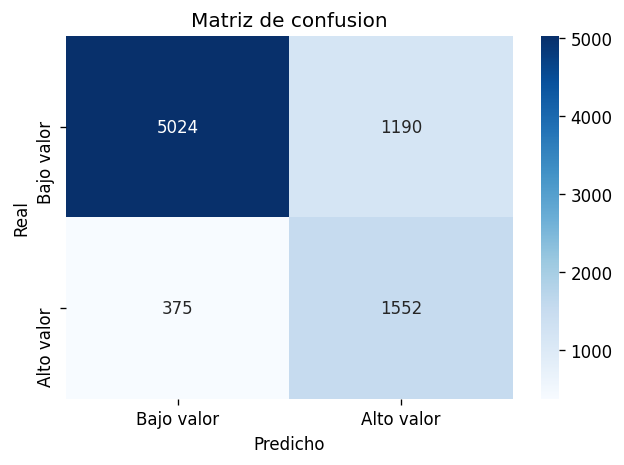

In [12]:
show_confusion_matrix(y_pred,y_test_v2)

### Buscamos ajustar hiperparametros con Grid Search Cross Validation

Para el cross validation vamos a usar 5 folds. 
En el param grid usamos valores de hiperparametros cercanos a los obtenidos como best params en random search.
Para que el grid search decida cual es la mejor combinacion vamos a utilizar roc auc como metrica.

Primero en seleccion 1

In [13]:
params = {'var_smoothing': np.logspace(0,-9, num=100)}
grid = GridSearchCV(estimator=gnb, 
                 param_grid=params, 
                 verbose=1, 
                 scoring='roc_auc') 
grid.fit(X_train_v1, y_train_v1)

grid.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   22.7s finished


{'var_smoothing': 1e-09}

Ahora para la seleccion 2

In [14]:
grid.fit(X_train_v2, y_train_v2)

grid.best_params_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   26.2s finished


{'var_smoothing': 1e-09}

In [15]:
var_smoothing = grid.best_params_["var_smoothing"]

## Rsultados de grid search en nuestros datasets

El resultado dio el hiperparametro var_smoothing identico al que viene por defecto por lo cual vamos a quedarnos con ese

# Resultado 

El modelo que mejor performó fue el que usaba la selección 1

In [16]:
columns_one_hot = ["estado_marital", "categoria_de_trabajo", "rol_familiar_registrado", "religion", "trabajo", "genero"]
data_holdout = encode_one_hot(data_holdout, columns_one_hot)
columns_sorted_numeric = ["educacion"]
data_holdout = encoding_sorted(data_holdout, columns_sorted_numeric)

In [17]:
best_clf = GaussianNB()
best_clf.fit(X_train_v1, y_train_v1)
predictions_holdout = best_clf.predict(data_holdout.drop(columns='id'))

In [18]:
write_predictions(predictions_holdout,"naive_bayes",data_holdout["id"])
